# Computational Image Analysis

### *BSc (Hons) Biology and Mathematics Joint Project*

## Import packages

Required Python packages are imported here.

In [3]:
import sys
import os
import re
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import Circle-Fit
import circle_fit as cf

# Import shapely
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

sys.path.append('C:/Users/sean2/Documents/Biology/Dissertation/MCSTracker/src/')

import mesh
import tracking

## Defining Functions

Define relevant functions for processing and analysing LECs

### Process Cellpose segmentations (from LEC Analysis code)

In [4]:
def read_in_images_unchanged(path_to_images):
    '''
    A function to read in images from a specified folder and store them in an array.
    
    Parameters
    ---------- 
    path_to_images: string
    Path to the folder containing the images, e.g. 'C:/Users/this_user/data/image_folder/'
    
    Output
    ------
    An array containing the image arrays.
    '''
    
    #List the names of the files in the specified folder numerically.
    list_of_file_paths = list_file_paths_in_folder_numerically(path_to_images)
    
    #Make an empty array to store the images.
    images=[]
    
    #Read in the input files and append them to the array. 
    #cv2.IMREAD_UNCHANGED ensures that the properties of the images (e.g. bit depth and number of channels) are not changed.        
    for frame_index in range(len(list_of_file_paths)):
        image = cv2.imread(list_of_file_paths[frame_index], cv2.IMREAD_UNCHANGED)
        image_copy = image.copy()
        images.append(image_copy)
    
    #Return the array of images.   
    return images

def list_file_paths_in_folder_numerically(path_to_folder):
    '''
    Numerically list file paths in the specified folder.
    
    Parameters
    ---------- 
    path_to_folder: string 
    Path to the folder containing the images, e.g. 'C:/Users/this_user/data/folder/'
    
    Output
    ------
    A 1D numpy array of numerically sorted file paths.
    '''
    
    #Make an empty array to store the file names.
    file_paths= []
        
    #Append the path to each file in the specified folder to the list of file names.
    #Loop through the names of all of the items in the folder.
    for files in os.listdir(path_to_folder):
        #If a given item is a file,
        if os.path.isfile(os.path.join(path_to_folder, files)):
            #Get its path,
            file_path = os.path.join(path_to_folder, files)
            #and append the path to the list.
            file_paths.append(file_path)
                
    #Sort the file paths numerically.
    sorted_file_paths = sort_filenames_numerically(file_paths)
    
    #Return the sorted file paths.
    return sorted_file_paths

def sort_filenames_numerically(list_of_file_names):
    '''
    Sort a list of file names numerically.
    '''      
    numerically_sorted_filenames=sorted(list_of_file_names, key=numerical_sorting_function)       
    return numerically_sorted_filenames
      

def numerical_sorting_function(filename):
    '''
    A helper function which sorts file names numerically. 
        
    '''
    nondigits = re.compile("\D")
    return int(nondigits.sub("", filename))


### Finding cell edges

* Obtain cell outline points (contours) and triple cell junctions (nodes) using functions programmed in MCSTracker code (Kursawe, 2016)
* Adjust nodes to closest contour point
* Obtain edges from adjusted nodes and contours

In [5]:
def get_contours(frame_image):
    '''
    Get a list of contours around each cell in the image adjusted to correct axis scaling.
    
    Parameters
    ----------
    frame_image : ndarray
        an image as integer numpy array

    Output
    ------
    contours : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a contour array for that segmented cell
    '''
    contours = {} # Initialise dictionary to store contours of each cell
    
    # Obtain contour list and cell ids using mesh function
    contour_list, cell_ids = mesh.get_contour_list(frame_image)
    
    # Loop through each cell to adjust contour points to the correct axis scaling
    for i, cell_id in enumerate(cell_ids):
        x = contour_list[i][0][:, 0, 0] # Extract x-coords
        y = 1024 - contour_list[i][0][:, 0, 1] # Extract y-coords and invert y-axis
        
        # Append inital point to the end of the x and y arrays
        x = np.append(x, [x[0]], axis=0) 
        y = np.append(y, [y[0]], axis=0)
        
        # Add adjusted array of contour points to cell id key value
        contours[cell_id] = np.column_stack((x, y))
        
    return contours

def get_mesh_sequence(path_to_images):
    '''
    Reads a folder of .tif files and transforms it into a sequence of mesh objects.
    
    Parameters
    ----------
    path_to_images : string
        path to folder that contains the segmented .tif files  

    Output
    ------
    mesh_sequence : list of Mesh instances
        elements of the list are instances of Mesh
    '''
    mesh_sequence = mesh.read_sequence_from_data(path_to_images)
    return mesh_sequence

def get_distance(a, b):
    '''
    Calculates the Euclidean distance between two points.
    '''
    return np.sqrt(np.sum((a - b)**2))

def adjust_nodes(nodes, contours):
    '''
    Adjusts the position of nodes to nearest contour point
    
    Parameters
    ----------
    nodes : list
        list of unadjusted nodes for a segmented cell
    
    contours : nparray
        2D array of contour points for a segmented cell
        
    Output
    ------
    adjusted_nodes : list
        list of nodes adjusted to the correct position
    '''
    adjusted_nodes = [] # Initialise list to store adjusted nodes
    
    # Loop through nodes
    for node in nodes:
        # Loop through contours to find closest the closest point
        for point in contours:
            # Find distance to node position
            this_distance = get_distance(point, node)
            # Set current point as the closest if under a certain specified distance value
            if this_distance < 1.4:
                closest_point = point
        # Add the adjusted node to the new list
        adjusted_nodes.append(closest_point)
        
    # Check if all nodes have been successfully adjusted
    if not (len(adjusted_nodes) == len(nodes)):
        raise Exception("Not all nodes were adjusted correctly")
        
    return adjusted_nodes

def get_nodes(frame_mesh, contours):
    '''
    Finds triple junctions (nodes) from mesh sequence and adjusts them to the nearest contour point.
    
    Parameters
    ----------
    frame_mesh : Mesh instance
        instance of a Mesh object which represents a specific frame
    
    contours : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a 2D contour array for that segmented cell

    Output
    ------
    nodes : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a list of adjusted nodes for that segmented cell
    '''
    nodes = {} # Initialise dictionary to store nodes of each cell
    cell_ids = frame_mesh.frame_id_dictionary # Extract ids of cells in Mesh object as dictionary
    
    # Loop through each cell id to extract nodes
    for cell_id in cell_ids.keys():
        # Get element object for current cell id
        current_element = frame_mesh.get_element_with_frame_id(cell_id)
        # Extract positions for each node in the cell
        current_nodes = [node.position for node in current_element.nodes]
        # Adjust nodes to position of nearest contour point
        current_adjusted_nodes = adjust_nodes(current_nodes, contours[cell_id])
        # Add node positions to cell id key value
        nodes[cell_id] = current_adjusted_nodes
    
    return nodes

def get_edges(nodes, contours):
    '''
    Find the edges of cells as the contour points between two nodes
    
    Parameters
    ----------
    nodes : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a list of adjusted nodes for that segmented cell
    
    contours : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is a 2D contour array for that segmented cell

    Output
    ------
    edges : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is an 2D array of edges for that segmented cell
    '''
    edges = {} # Initialise dictionary to store edges of each cell
    
    # Loop through cells to obtain current nodes and contours
    for cell_id in nodes:
        current_nodes = nodes[cell_id]
        current_contours = contours[cell_id]
        n = len(current_nodes)
        
        current_edges = [] # Initialise list of edges for current cell
        # Loop for number of nodes
        for i in range(n):
            node1 = current_nodes[i] # Set first node
            # If the first node is the last in the list, set the second as the first in the list
            if (i+1) == n:
                node2 = current_nodes[0]
            # Otherwise, set the second node as the next in the list
            else:
                node2 = current_nodes[i+1]       
              
            # Find indices of the contour points equal to the nodes
            index1 = np.where((current_contours == node1).all(axis=1))[0]
            index2 = np.where((current_contours == node2).all(axis=1))[0]
            
            # If two indices are found for the index1, choose that with shortest distance to index2
            if (len(index1) > 1):
                if (np.abs(index1[0]-index2) < np.abs(index1[1]-index2)):
                    index1 = index1[0]
                else:
                    index1 = index1[1]
            else:
                index1 = index1[0] # Convert from array to scalar object
            
            # If two indices are found for the index2, choose that with shortest distance to index1
            if (len(index2) > 1):
                if (np.abs(index2[0]-index1) < np.abs(index2[1]-index1)):
                    index2 = index2[0]
                else:
                    index2 = index2[1]
            else:
                index2 = index2[0] # Convert from array to scalar object
            
            # Check if edge crosses index boundary of contour points 
            if index1 > index2:
                # Extract current edge between the two index points
                current_edge = np.concatenate((current_contours[int(index1):-1], current_contours[0:int(index2)]), axis=0)
                current_edges.append(current_edge)
            else:
                current_edge = current_contours[int(index1):int(index2)]
                current_edges.append(current_edge)
            
        edges[cell_id] = current_edges
    return edges


### Detecting Lamellipodia

* Define a geometric circle fitting method
* Normalise RMS error by arc length to get quality of fit
* Merge edges based on quality of fit
* Detect lamellipodia based on curvature, quality of fit and edge length

In [35]:
def get_closest_point_on_circle(point, centre, r):
    '''
    Find the point closest to the current point on a given circle.
    
    Parameters
    ----------
    point : list
        list containing x and y coordinate of a given point
    
    centre : list
        list containing x and y coordinate of the centre of a circle
        
    r : float
        radius of a circle
    
    Output
    ------
    closest_point : list
        list containing x and y coordinate of closest point on the given circle.
    '''
    # Calculate the distance from the circle centre to the point
    distance = get_distance(point, centre)
    # If the point is on the circle, return the point itself
    if distance == r:
        return point
    # Calculate direction vector from centre to the point
    direction = (point - centre) / distance
    # Find closest point on the circle by scaling direction vector
    closest_point = centre + r * direction
    return closest_point

def get_arc_length(edge, centre, r):
    '''
    Calculate the arc length of a fitted edge.
    
    Parameters
    ----------
    edge : nparray
        2D array of a given cell edge
    
    centre : list
        list containing x and y coordinate of the centre of a circle
        
    r : float
        radius of a circle
    
    Output
    ------
    arc_length : float
        value of arc length of edge segment    
    '''
    # Find arc endpoints (p1 and p3) and middle point (p2)
    # (Need to calculate two arc lengths to control for longer arcs)
    p1 = get_closest_point_on_circle(edge[0], centre, r)
    p2 = get_closest_point_on_circle(edge[(len(edge)-1) // 2], centre, r)
    p3 = get_closest_point_on_circle(edge[-1], centre, r)
    
    # Get length of chord 
    chord1 = get_distance(p1, p2)
    chord2 = get_distance(p2, p3)
    
    # Calculate the central angles
    # (One half of chord is the side of a right angled triangle)
    theta1 = 2 * np.arcsin(chord1 / (2 * r))
    theta2 = 2 * np.arcsin(chord2 / (2 * r))
    
    # Calculate arc length
    arc_length = (theta1 + theta2) * r
    return arc_length    

def get_initial_guesses(edge):
    '''
    Compute initial guess for center coordinates (xc, yc) and radius (r) of a circle
    based on given edge.

    Parameters
    ----------
    edge : nparray
        2D array of a given cell edge

    Output
    ------
    inits : nparray
        1D containing initial guesses (floats) for centre coords and radius of the circle
    '''
    # Compute centroid of edge points
    centroid = np.mean(edge, axis=0)

    # Use centroid as initial guess for center coordinates (xc, yc)
    xc, yc = centroid

    # Compute distances from the centroid to each point
    distances = np.linalg.norm(edge - centroid, axis=1)

    # Use the maximum distance as the initial guess for the radius
    r = np.max(distances)
    
    inits = np.array([xc, yc, r])
    return inits

def get_circle_fit(edge):
    '''
    Geometric circle fit (minimizing orthogonal distances) based on the standard Levenberg-Marquardt scheme in the full
    (a,b,R) parameter space. Returns RMS error normalised by arc length.
    
    Parameters
    ----------
    edge : nparray
        2D array of a given cell edge
        
    inits : nparray
        array of [xc, yc, r] initial guess
        
    Output
    ------
    xc : float
        x coordinate of the circle fit
        
    yc : float
        y coordinate of the circle fit
        
    r : float
        radius of the circle fit
        
    norm_sigma : float
        sigma (RMS of error) of the circle fit normalised with arc length
    '''
    # Check that edges are of sufficient length
    if len(edge) < 3:
        raise ValueError("Edge must contain three or more points")        
    
    # Get initial guesses for circle fit
    inits = get_initial_guesses(edge)
    #xci, yci, ri, sigmai = cf.taubinSVD(edge)
    #inits = np.array([xci, yci, ri])
    
    # Get geometric circle fit using initial values
    for i in range(10):
        try:
            xc, yc, r, sigma = cf.lm(edge, inits)
            break
        except Exception:
            inits += 10
    
    # Normalise the sigma value by arc length
    arc_length = get_arc_length(edge, [xc, yc], r)
    norm_sigma = sigma / arc_length
    
    return xc, yc, r, norm_sigma

def get_midpoint(point1, point2):
    '''
    Calculate the midpoint between two 2D points.
    '''
    x1, y1 = point1
    x2, y2 = point2
    mid_x = (x1 + x2) / 2
    mid_y = (y1 + y2) / 2
    return (mid_x, mid_y)

def get_cell_polygon(edges):
    '''
    Get Shapely polygon of current cell.
    '''
    cell_points = [] # Initialise list to store cell points
    # Loop through cell edges to add first and middle points
    for edge in edges:
        cell_points.append(edge[0])
        cell_points.append(edge[len(edge)//2])
    return Polygon(cell_points)

def is_merge(edge1, edge2, cell_edges, sigma = 0.016):
    '''
    Decide whether to merge two edges. Check convexity and quality of a combined circle fit.
    
    Parameters
    ----------
    edge1, edge2 : nparrays
        2D arrays of given cell edges
        
    cell_edges : nparray
        list of 2D arrays of edges of a given cell
    
    sigma : float
        threshold quality of fit value for merging. Default is 0.016
        
    Output
    ------
    Boolean. True if edges should be merged.
    '''
    # Need three or more points to fit a circle
    if len(edge1) < 3 or len(edge2) < 3:
        return False
    
    # Check for convexity
    # Get Shapely polygon of current cell
    cell_poly = get_cell_polygon(cell_edges)
    # Calculate midpoint between ends of given edges
    midpoint1 = get_midpoint(edge1[0], edge1[-1])
    midpoint2 = get_midpoint(edge2[0], edge2[-1])
    # Get Shapely point element of each midpoint
    point1 = Point(midpoint1)
    point2 = Point(midpoint2)
    # Do not merge if midpoints are not contained in cells (i.e., edges are concave)
    if not (cell_poly.contains(point1) and cell_poly.contains(point1)):
        return False
    
    # Get circle fits for each edge
    xc1, yc1, r1, sigma1 = get_circle_fit(edge1)
    xc2, yc2, r2, sigma2 = get_circle_fit(edge2)
    
    # Get circle fit for combined edge
    combined_edge = np.concatenate((edge1, edge2))
    xcc, ycc, rc, sigmac = get_circle_fit(combined_edge)
    
    # Do not merge if quality of fit for combined fit is over threshold value 
    if sigmac > sigma:
        return False
    
    return True

def get_merged_edges(edges, sigma = 0.016):
    '''
    Find new list of merged edges of cells in a frame. Edges are merged based on convexity and quality of a combined circle fit.
    
    Parameters
    ----------
    edges : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is an 2D array of edges for that segmented cell
    
    sigma : float
        threshold quality of fit value for merging. Default is 0.016
    
    Output
    ------
    merged_edges : dictionary
        each key is the integer value of a segmented cell in the frame
        each value is an 2D array of merged edges for that segmented cell
    '''
    merged_edges = {} # Initialise dictionary to store merged edges for each edge
    
    # Loop through each cell
    for cell_id in edges:
        current_edges = edges[cell_id] # Extract the edges of the current cell
        n = len(current_edges)
        current_merge = [] # Initialise list to store current merged edges
        
        # Loop for each edge in the cell
        for i in range(n):
            # If the first iteration...
            if not current_merge:
                # Set the first edges to check for merge
                edge1 = current_edges[i-1]
                edge2 = current_edges[i]
                # Add merged edge if they meet criteria 
                if is_merge(edge1, edge2, current_edges):
                    current_merge.append(np.concatenate((edge1, edge2)))
                    initial_merge = True # Keep track if initial edges were merged
                else:
                    current_merge.append(edge2) # Add second edge if they do not meet criteria
                    initial_merge = False
            
            # If the last iteriation and if edges were merged on the first iteration...
            elif i == n-1 and initial_merge:
                # Set the edges from the merged list
                edge1 = current_merge[-1]
                edge2 = current_merge[0]
                # Add merged edge if they meet criteria and remove unmerged final edge in merged list
                if is_merge(edge1, edge2, current_edges):
                    current_merge[0] = np.concatenate((edge1, edge2))
                    current_merge[:-1]
                    
            else:
                # Set first edge as the last in the merged list
                edge1 = current_merge[-1]
                # Set the second edge from the current edge list
                edge2 = current_edges[i]
                # Add the merged edge if they meet criteria
                if is_merge(edge1, edge2, current_edges):
                    current_merge[-1] = np.concatenate((edge1, edge2))
                # Add the unmerged current edge if not
                else:
                    current_merge.append(edge2)
        # Add list of merged edges at current cell id
        merged_edges[cell_id] = current_merge
    return merged_edges

def is_lamellipodium(edge, cell_edges, curvature = 0.005, sigma = 0.02, proportion = 0.2, getstats = False):
    '''
    Decide whether an edge is a lamellipodium and receive the selection data (optional).
    
    Parameters
    ----------
    edge : nparray
        2D array of given cell edge
        
    cell_edges : nparray
        list of 2D arrays of edges of a given cell
    
    curvature : float
        threshold curvature value for lamellipodia. Default is 0.005
        
    sigma : float
        threshold quality of fit value for lamellipodia. Default is 0.02
    
    proportion : float
        threshold value for length of edge proportional to total cell edge for lamellipodia. Default is 0.2
    
    getstats : Boolean
        decides whether selection data is output. Default is no data output
        
    Output
    ------
    is_lamel : Boolean
        True if given edge is detected as a lamellipodium
    
    curvature : float (optional)
        curvature value for given edge
        
    sigma : float (optional)
        quality of fit value for given edge
    
    proportion : float (optional)
        value for length of edge proportional to total cell edge for given edge        
    '''
    # Check whether edge contains more than two points
    if len(edge) < 3:
        raise ValueError("Edge must contain three or more points")
    
    # Get combined array of cell edges
    cell_outline = np.concatenate(cell_edges)
    # Get Shapely polygon of current cell
    cell_poly = get_cell_polygon(cell_edges)
    
    # Set lamellipodia identifier as False
    is_lamel = False
    # Get geometric circle fit for current edge
    xc, yc, r, sigmai = get_circle_fit(edge)
    # Calculate curvature and proportional length
    curvaturei = 1 / r
    proportioni = len(edge)/len(cell_outline)
    
    # Check if edge fulfils given threshold criteria
    if curvaturei > curvature and sigmai < sigma and proportioni > proportion:
        # Check for convexity
        midpoint = get_midpoint(edge[0], edge[-1])
        point = Point(midpoint)
        if cell_poly.contains(point):
            is_lamel = True
    
    # Return selection data if asked
    if getstats:
        return [is_lamel, curvaturei, sigmai, proportioni]
    else:
        return is_lamel


### Lamellipodia Analysis

In [41]:
def get_direction(lamellipodium):
    '''
    Calculate the direction of a given lamellipodium in radians using np.arctan2 function
    
    Parameters
    ----------
    lamellipodium : nparray
        2D array of a given lamellipodium
    
    Output
    ------
    direction : float
        direction of the lamellipodium in radians adjusted for each quadrant
    '''
    # Fit a circle to the lamellipodium
    xc, yc, r, sigma = get_circle_fit(lamellipodium)
    
    # Find the median point in the lamellipodium array
    median = lamellipodium[(len(lamellipodium) - 1) // 2]
    # Calculate the difference between the x- and y-coords of the centre of the fitted circle and the median point
    dx = median[0] - xc
    dy = median[1] - yc
    
    # Calculate direction of the vector using arctan2 numpy function
    direction = np.arctan2(dy, dx)
    return direction


## Code usage

### Example 1 (AB150722a)

#### Processing Cellpose segmentations

In [7]:
# Define the path to the tracked segmentations   
path_to_segmentations = 'C:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence/'
# Read in the tracked segmentations
segmentations = read_in_images_unchanged(path_to_segmentations)
# Create mesh sequence of cells in each frame
mesh_sequence = get_mesh_sequence(path_to_segmentations)

readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_0_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_1_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_2_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_3_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_4_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_5_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_6_master.tif
readingC:/Users/sean2/Documents/Biology/Dissertation/19_frames_test/master_segmentation_sequence\AB150722aframe_7_master.tif


#### Finding edges and detecting Lamellipodia

Data is gathered in a Pandas dataframe for quantitative analysis

In [44]:
headers = ['Lamellipodia', 'Curvature', 'Quality of Fit', 'Proportional Length', 'Direction of Movement', 'Frame']
df = pd.DataFrame(columns = headers)

nframes = len(mesh_sequence)
for n in range(nframes):
    current_mesh = mesh_sequence[n]
    current_frame = segmentations[n] 
    
    contours = get_contours(current_frame)
    nodes = get_nodes(current_mesh, contours)
    edges = get_edges(nodes, contours)
    
    merged_edges = get_merged_edges(edges)
    for cell_id in merged_edges:
        for edge in merged_edges[cell_id]:
            if len(edge) >= 3:
                data = is_lamellipodium(edge, merged_edges[cell_id], getstats=True)
                if data[0]:
                    data.append(get_direction(edge))
                else:
                    data.append(None)
                data.append(n)
                df.loc[len(df)] = data

C:\Users\sean2\anaconda3\envs\AnalysisPipelineEnvironment\Lib\site-packages\circle_fit\circle_fit.py:221: RuntimeWarning: invalid value encountered in divide
  _j = np.array([-Dx / D, -Dy / D, -np.ones(len(x))]).transpose()
C:\Users\sean2\anaconda3\envs\AnalysisPipelineEnvironment\Lib\site-packages\circle_fit\circle_fit.py:221: RuntimeWarning: invalid value encountered in divide
  _j = np.array([-Dx / D, -Dy / D, -np.ones(len(x))]).transpose()


#### Visual Analysis

#### Quantitative Analysis

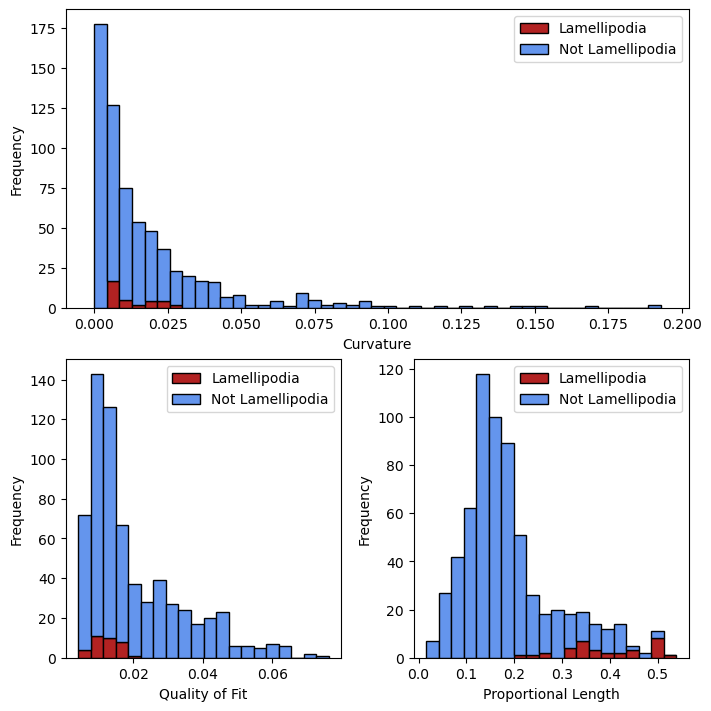

In [51]:
# Set data based on whether it is defined as a lamellipodia
lam_true = df[df['Lamellipodia'] == True]
lam_false = df[df['Lamellipodia'] == False]

# Plot histograms
fig = plt.figure(figsize=(7, 7), constrained_layout=True)

plt.subplot2grid((2, 2), (0, 0), colspan=2)  # colspan=2 indicates the first subplot spans 2 columns
plt.hist([lam_true['Curvature'], lam_false['Curvature']], bins=45, color=['firebrick','cornflowerblue'], edgecolor='black', label=['Lamellipodia', 'Not Lamellipodia'], stacked=True)
plt.legend(loc='upper right')
plt.xlabel('Curvature')
plt.ylabel('Frequency')

plt.subplot2grid((2, 2), (1, 0))  # This subplot will be in the second row, first column
plt.hist([lam_true['Quality of Fit'], lam_false['Quality of Fit']], bins=20, color=['firebrick','cornflowerblue'], edgecolor='black', label=['Lamellipodia', 'Not Lamellipodia'], stacked=True)
plt.legend(loc='upper right')
plt.xlabel('Quality of Fit')
plt.ylabel('Frequency')

plt.subplot2grid((2, 2), (1, 1))  # This subplot will be in the second row, second column
plt.hist([lam_true['Proportional Length'], lam_false['Proportional Length']], bins=20, color=['firebrick','cornflowerblue'], edgecolor='black', label=['Lamellipodia', 'Not Lamellipodia'], stacked=True)
plt.legend(loc='upper right')
plt.xlabel('Proportional Length')
plt.ylabel('Frequency')

#plt.savefig('lamellipodia_histograms.png', dpi=1200)
plt.show()

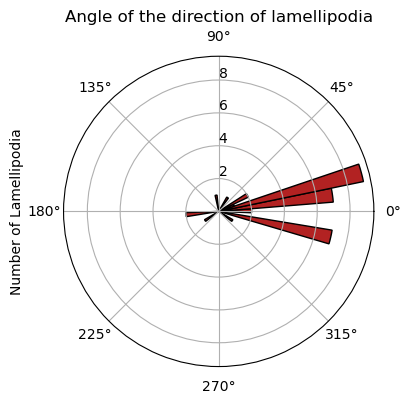

In [53]:
plt.figure(figsize = (4,4), constrained_layout = True)
ax = plt.subplot(projection='polar')
ax.set_rlabel_position(90)
ax.hist(lam_true['Direction of Movement'], bins = 40, color='firebrick', edgecolor='black')
plt.text(-0.15, 0.5, 'Number of Lamellipodia', rotation='vertical', va='center', ha='center', transform=ax.transAxes)
plt.title('Angle of the direction of lamellipodia')
plt.show()

### Example 2 ()

#### Processing Cellpose segmentations

In [56]:
# Define the path to the tracked segmentations   
path_to_segmentations = 'C:/Users/sean2/Documents/Biology/Dissertation/Lydia_images/'
# Read in the tracked segmentations
segmentations = read_in_images_unchanged(path_to_segmentations)
# Create mesh sequence of cells in each frame
mesh_sequence = get_mesh_sequence(path_to_segmentations)

readingC:/Users/sean2/Documents/Biology/Dissertation/Lydia_images\1_DE-cad-GFP_im_0_0.tiff


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


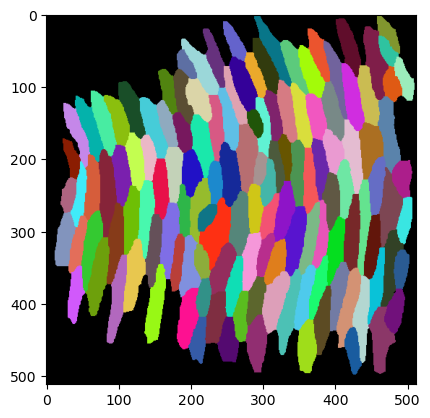

In [60]:
first_frame = segmentations[0]
#print(first_frame.shape)
plt.figure()
plt.imshow(first_frame)
#plt.savefig('first_frame_values.png', dpi=1200);
plt.show()

#### Finding edges and detecting Lamellipodia

Data is gathered in a Pandas dataframe for quantitative analysis

In [44]:
headers = ['Lamellipodia', 'Curvature', 'Quality of Fit', 'Proportional Length', 'Direction of Movement', 'Frame']
df = pd.DataFrame(columns = headers)

nframes = len(mesh_sequence)
for n in range(nframes):
    current_mesh = mesh_sequence[n]
    current_frame = segmentations[n] 
    
    contours = get_contours(current_frame)
    nodes = get_nodes(current_mesh, contours)
    edges = get_edges(nodes, contours)
    
    merged_edges = get_merged_edges(edges)
    for cell_id in merged_edges:
        for edge in merged_edges[cell_id]:
            if len(edge) >= 3:
                data = is_lamellipodium(edge, merged_edges[cell_id], getstats=True)
                if data[0]:
                    data.append(get_direction(edge))
                else:
                    data.append(None)
                data.append(n)
                df.loc[len(df)] = data

C:\Users\sean2\anaconda3\envs\AnalysisPipelineEnvironment\Lib\site-packages\circle_fit\circle_fit.py:221: RuntimeWarning: invalid value encountered in divide
  _j = np.array([-Dx / D, -Dy / D, -np.ones(len(x))]).transpose()
C:\Users\sean2\anaconda3\envs\AnalysisPipelineEnvironment\Lib\site-packages\circle_fit\circle_fit.py:221: RuntimeWarning: invalid value encountered in divide
  _j = np.array([-Dx / D, -Dy / D, -np.ones(len(x))]).transpose()


#### Visual Analysis

#### Quantitative Analysis

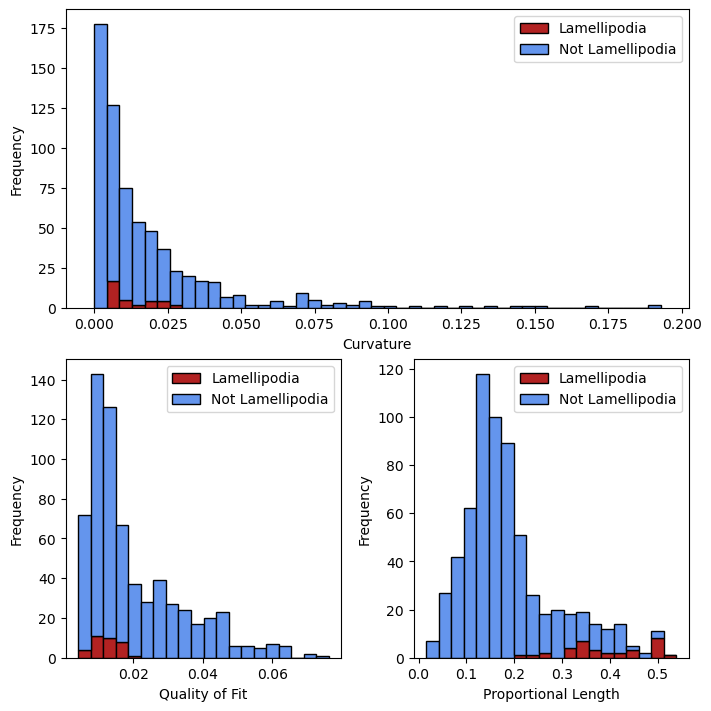

In [51]:
# Set data based on whether it is defined as a lamellipodia
lam_true = df[df['Lamellipodia'] == True]
lam_false = df[df['Lamellipodia'] == False]

# Plot histograms
fig = plt.figure(figsize=(7, 7), constrained_layout=True)

plt.subplot2grid((2, 2), (0, 0), colspan=2)  # colspan=2 indicates the first subplot spans 2 columns
plt.hist([lam_true['Curvature'], lam_false['Curvature']], bins=45, color=['firebrick','cornflowerblue'], edgecolor='black', label=['Lamellipodia', 'Not Lamellipodia'], stacked=True)
plt.legend(loc='upper right')
plt.xlabel('Curvature')
plt.ylabel('Frequency')

plt.subplot2grid((2, 2), (1, 0))  # This subplot will be in the second row, first column
plt.hist([lam_true['Quality of Fit'], lam_false['Quality of Fit']], bins=20, color=['firebrick','cornflowerblue'], edgecolor='black', label=['Lamellipodia', 'Not Lamellipodia'], stacked=True)
plt.legend(loc='upper right')
plt.xlabel('Quality of Fit')
plt.ylabel('Frequency')

plt.subplot2grid((2, 2), (1, 1))  # This subplot will be in the second row, second column
plt.hist([lam_true['Proportional Length'], lam_false['Proportional Length']], bins=20, color=['firebrick','cornflowerblue'], edgecolor='black', label=['Lamellipodia', 'Not Lamellipodia'], stacked=True)
plt.legend(loc='upper right')
plt.xlabel('Proportional Length')
plt.ylabel('Frequency')

#plt.savefig('lamellipodia_histograms.png', dpi=1200)
plt.show()

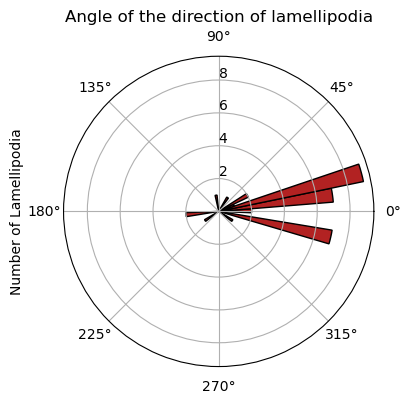

In [53]:
plt.figure(figsize = (4,4), constrained_layout = True)
ax = plt.subplot(projection='polar')
ax.set_rlabel_position(90)
ax.hist(lam_true['Direction of Movement'], bins = 40, color='firebrick', edgecolor='black')
plt.text(-0.15, 0.5, 'Number of Lamellipodia', rotation='vertical', va='center', ha='center', transform=ax.transAxes)
plt.title('Angle of the direction of lamellipodia')
plt.show()